# **Pedestrian Detection Using YOLO8x6 Model**
## **Casey McDonald (Computer Vision and Traffic Analysis Team) Trimester 2 2025**


**Basic information about this notebook:**
* Task: Single‑class pedestrian detection
* Goal: Locate pedestrians in suburban settings
* Framework: Ultralytics YOLOv8 (PyTorch) in Google Colab (T4)
* Splits: train/val/test with data.yaml (paths + names: ["pedestrian"]).
* Models tried: yolov8l.pt, yolov8x6.pt (best accuracy), single class

**Observations:**
* Moving from YOLOv8 L to X6 improved recall slightly
* Increasing imgsz beyond 640 helps with identifying and learning small pedestrians but can cause crashes due to RAM and GPU limitations. This may be improved upon in future semesters.
* Class‑mixing (person + face) worsened results; single‑class showed stronger accuracy and used for this model.
* SGD showed improved overall accuracy

**Challenges:**
* Decent RAM required for larger datasets or more complex models
* GPU requirements are large and I needed to access Colab PRO in order to run models on my machine

This notebook documents model development on Dataset A (video-derived)—a collection of 477 frames sampled from urban video footage. Scenes include pedestrians moving through crosswalks, sidewalks, and other street settings. It’s compact, real-world, and purpose-built for testing pedestrian detection in lived city conditions.

**Dataset citation**

 *ZSL. (2024). pedestrian dataset. Roboflow Universe. https://universe.roboflow.com/zsl-hmu2b/pedestrian-w16dt
 (Accessed 2025-09-15)*

 Ethical considerations:


## Use case information:

**Problem statement**:
Urban environments present safety challenges for pedestrians, with traffic accidents and overcrowding incidents providing risks to public safety. Traditional surveillance systems lack the capability to automatically detect and locate pedestrians in real-time, limiting their effectiveness in preventing accidents and managing crowd dynamics. There is a  need for an intelligent computer vision systems that can accurately identify pedestrian locations in urban image frames to enable and aid in safety interventions, traffic management, and emergency response coordination.

**Solution**:
Develop a YOLO8x6 model to predict the location of pedestrians in image frames to help with safety in urban environments. The solution uses advanced convolutional neural network architectures to provide pedestrian detection with accuracy. This is provides the foundations for adding further complexity and additional crowd density focus in future trimesters.

**Challenges**:
Original focus was on crowd density analysis exceeded available GPU memory and computational time resources. Tried dataset size reduction strategies, but processing requirements remained beyond system capabilities. Refocused project scope to concentrate exclusively on pedestrian detection to maximize accuracy with more simplicity, with the intention of expansion of the use case. Successfully overcame technical constraints to achieve 89.8% mAP50 through focused optimisation and parameter tuning.

**Future scope**:
* Expand training dataset with increased image variety and environmental conditions
* Focus on integrating face recognition capabilities for enhanced person identification (started this using CrowdHuman model)
* Implement multi-scale detection for improved small object recognition
* Explore VisDrone dataset for comprehensive crowd analysis capabilities
* Develop hybrid architecture combining pedestrian detection with density estimation
* Implement real-time crowd monitoring and alert systems

Results

In [6]:
# required installs and imports
!pip install torch
!pip install ultralytics
!pip install torch torchvision torchaudio
!pip install matplotlib
!pip install opencv-python
!pip install ultralytics
import pandas as pd, os, shutil, random, yaml, torch, time, glob, pprint
import numpy as np
from google.colab import drive
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image, display
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
# Mount drive and point to the directory
drive.mount('/content/drive')
directory_path = "/content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8" # wherever directory the data is loaded to

DIR = directory_path
YAML_IN   = os.path.join(DIR, "data.yaml")

Mounted at /content/drive


In [8]:
# Look at the YAML File confirm structure
if os.path.exists(YAML_IN):
    print(f"YAML found: {YAML_IN}")

    print("\nYAML content:")
    with open(YAML_IN, 'r') as file:
        data_config = yaml.safe_load(file)
        print(yaml.dump(data_config, default_flow_style=False))

YAML found: /content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8/data.yaml

YAML content:
names:
  0: pedestrian
path: /content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8
test: test/images
train: train/images
val: val/images



In [9]:
ratios   = {"train": 0.70, "val": 0.20, "test": 0.10}
random.seed(42)

paths = {
    s: {"img": os.path.join(DIR, s, "images"),
        "lbl": os.path.join(DIR, s, "labels")}
    for s in ("train", "val", "test")
}
for d in (p for v in paths.values() for p in v.values()):
    os.makedirs(d, exist_ok=True)

ex = (".jpg", ".jpeg", ".png")
def paired(img_dir, lbl_dir):
    return [f for f in os.listdir(img_dir)
            if f.lower().endswith(ex)
            and os.path.exists(os.path.join(lbl_dir, os.path.splitext(f)[0] + ".txt"))]

def move_pair(src, dst, fname):
    stem = os.path.splitext(fname)[0]
    shutil.move(os.path.join(src["img"], fname), os.path.join(dst["img"], fname))
    shutil.move(os.path.join(src["lbl"], stem + ".txt"), os.path.join(dst["lbl"], stem + ".txt"))

current = {s: paired(p["img"], p["lbl"]) for s, p in paths.items()}
total   = sum(len(v) for v in current.values())
if total == 0: raise RuntimeError("No paired images+labels found in any split.")

targets = {
    "val":  round(total * ratios["val"]),
    "test": round(total * ratios["test"]),
}
targets["train"] = total - targets["val"] - targets["test"]

counts = {s: len(v) for s, v in current.items()}

for s in ("val", "test"):
    over = counts[s] - targets[s]
    if over > 0:
        random.shuffle(current[s])
        for f in current[s][:over]:
            move_pair(paths[s], paths["train"], f)
        counts["train"] += over
        counts[s]       -= over

current["train"] = paired(paths["train"]["img"], paths["train"]["lbl"])
counts["train"]  = len(current["train"])

train_pool = set(current["train"])
for s in ("val", "test"):
    need = targets[s] - counts[s]
    if need > 0:
        pick = list(train_pool)
        random.shuffle(pick)
        take = pick[:need]
        for f in take:
            move_pair(paths["train"], paths[s], f)
        train_pool -= set(take)
        counts["train"] -= len(take)
        counts[s]       += len(take)


In [10]:
final = {s: len(paired(paths[s]["img"], paths[s]["lbl"])) for s in ("train","val","test")}
total = sum(final.values())

for s in ("train", "val", "test"):
    pct = (final[s] / total * 100) if total > 0 else 0
    print(f"{s}: {final[s]} images, {final[s]} annotations ({pct:.2f}%)")

print(f"total: {total} images (paired)")

train: 334 images, 334 annotations (70.02%)
val: 95 images, 95 annotations (19.92%)
test: 48 images, 48 annotations (10.06%)
total: 477 images (paired)


In [11]:
# update the YAML file to ensure the correct information
def update_yaml_file(dataset_path):
    yaml_path = os.path.join(dataset_path, 'data.yaml')

    yaml_content = f"""# Dataset
path: {dataset_path}
train: train/images
val: val/images
test: test/images

# Classes
names:
  0: pedestrian
"""
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)

    print("YAML file content:")
    print(yaml_content)

    return yaml_path

yaml_file_path = update_yaml_file(DIR)

YAML file content:
# Dataset
path: /content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8
train: train/images
val: val/images
test: test/images

# Classes
names:
  0: pedestrian



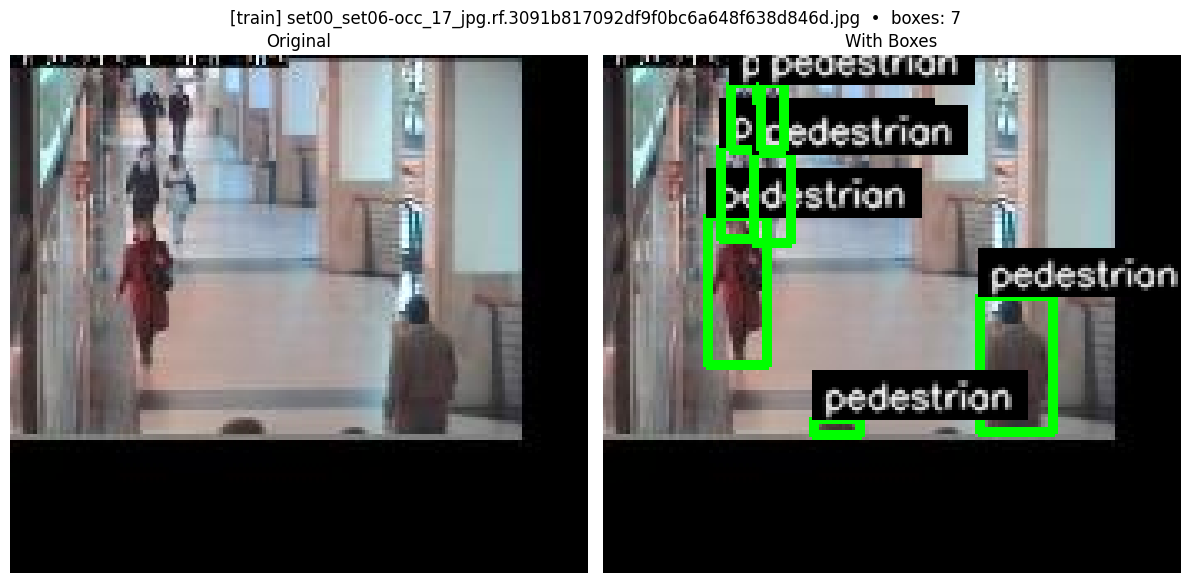

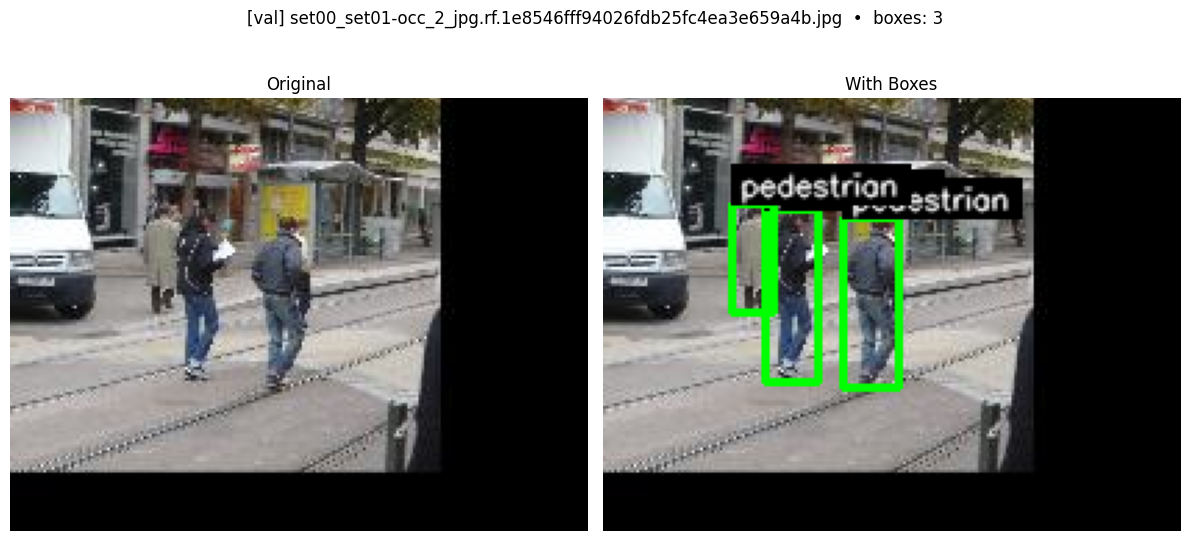

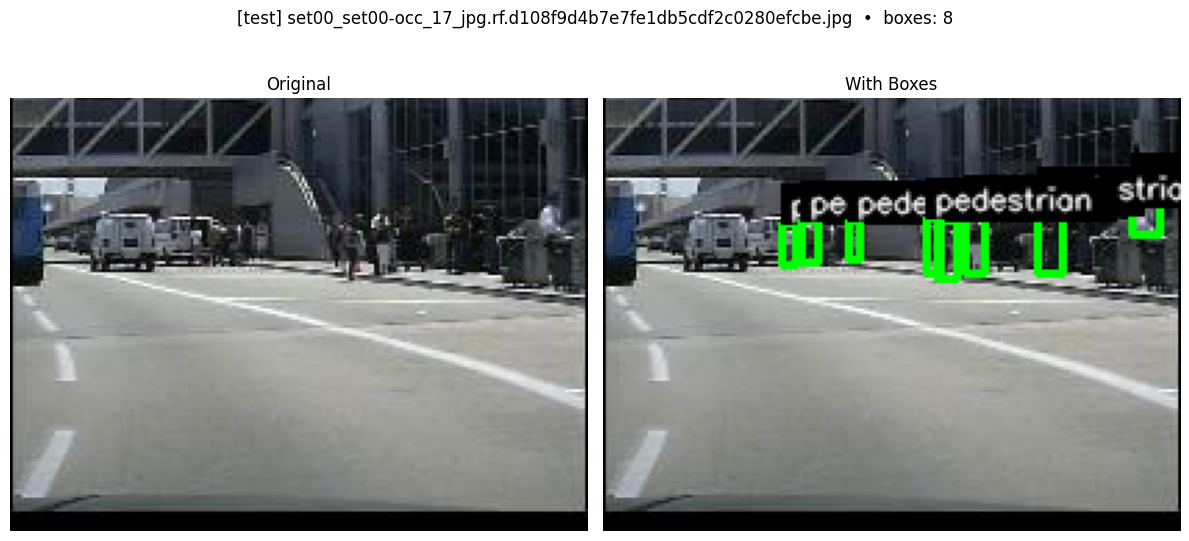

In [12]:
# example samples print and dispaly
IMG_EXTS = (".jpg", ".jpeg", ".png")

def load_class_names(dataset_root):
    for cand in [Path(dataset_root, "data.yaml"), Path(dataset_root, "dataset.yaml")]:
        if cand.exists():
            with open(cand, "r") as f:
                cfg = yaml.safe_load(f)
                if isinstance(cfg, dict) and "names" in cfg:
                    names = cfg["names"]
                    if isinstance(names, dict):
                        return [names[k] for k in sorted(names.keys())]
                    return list(names)
    return ["pedestrian"]

CLASS_NAMES = load_class_names(DIR)

def list_images(img_dir):
    if not os.path.isdir(img_dir): return []
    return [f for f in os.listdir(img_dir) if f.lower().endswith(IMG_EXTS)]

def draw_boxes_on_image(img_bgr, label_path, class_names):

    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    with open(label_path, "r") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    font_scale = max(0.35, min(0.5, h / 1200))
    thickness  = 1

    for ln in lines:
        parts = ln.split()
        if len(parts) != 5:
            continue
        cls, xc, yc, bw, bh = map(float, parts)
        cls = int(cls)
        name = class_names[cls] if 0 <= cls < len(class_names) else f"id{cls}"

        x1 = int((xc - bw/2) * w); y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w); y2 = int((yc + bh/2) * h)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w-1, x2), min(h-1, y2)

        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)

        (tw, th), _ = cv2.getTextSize(name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
        y_text_top = max(0, y1 - th - 6)
        cv2.rectangle(img, (x1, y_text_top), (x1 + tw + 6, y1), (0,0,0), -1)     # bg
        cv2.putText(img, name, (x1 + 3, y1 - 3),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,255,255), thickness, cv2.LINE_AA)

    return img, len(lines)

def show_samples_for_split(dataset_root, split="train", k=3, seed=None):
    img_dir = os.path.join(dataset_root, split, "images")
    lbl_dir = os.path.join(dataset_root, split, "labels")

    imgs = list_images(img_dir)

    if seed is not None:
        rnd = random.Random(seed)
        picks = rnd.sample(imgs, k=min(k, len(imgs)))
    else:
        picks = random.sample(imgs, k=min(k, len(imgs)))

    for fname in picks:
        img_path = os.path.join(img_dir, fname)
        lbl_path = os.path.join(lbl_dir, os.path.splitext(fname)[0] + ".txt")

        img_bgr = cv2.imread(img_path)

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        boxed_rgb, n = draw_boxes_on_image(img_bgr, lbl_path, CLASS_NAMES)

        plt.figure(figsize=(12, 6))
        plt.suptitle(f"[{split}] {fname}  •  boxes: {n}", fontsize=12)
        plt.subplot(1,2,1); plt.imshow(img_rgb);   plt.title("Original");   plt.axis("off")
        plt.subplot(1,2,2); plt.imshow(boxed_rgb); plt.title("With Boxes"); plt.axis("off")
        plt.tight_layout()
        plt.show()

def show_samples_for_all_splits(dataset_root, k_per_split=3, seed=None):
    for split in ("train", "val", "test"):
        show_samples_for_split(dataset_root, split=split, k=k_per_split, seed=seed)

show_samples_for_all_splits(DIR, k_per_split=1) # 1 sample for each train, val and test


In [13]:
# training funct
def start_training():

    model = YOLO("yolov8x6.pt") # using pretrained model

    # training config
    config = {
        "data": YAML_IN,                  # dataset yaml
        "epochs": 20,                     # how many passes over data
        "imgsz": 704,                     # input image sizes
        "batch": 8,                       # batch size
        "patience": 20,
        "optimizer": "SGD",               # optimizer chosen
        "cos_lr": True,                   # cosine learning rate schedule
        "momentum": 0.937,
        "weight_decay": 0.0005,
        "lrf": 0.01,                      # final lr factor
        "warmup_epochs": 5,
        "lr0": 0.01,                      # initial learning rate
        "device": "0",                    # GPU index (0 = first GPU)
        "project": "pedestrian_detection",# folder name for the save runs
        "name": "yolov8l_pedestrian_1",   # run name
        "exist_ok": True,                 # overwrite if exists
        "verbose": True,
        "single_cls": True,
    }

    print("\nTraining with configuration:")
    for k, v in config.items():
        print(f"  {k}: {v}")

    results = model.train(**config)
    return model, results

trained_model, training_results = start_training()


Training with configuration:
  data: /content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8/data.yaml
  epochs: 20
  imgsz: 704
  batch: 8
  patience: 20
  optimizer: SGD
  cos_lr: True
  momentum: 0.937
  weight_decay: 0.0005
  lrf: 0.01
  warmup_epochs: 5
  lr0: 0.01
  device: 0
  project: pedestrian_detection
  name: yolov8l_pedestrian_1
  exist_ok: True
  verbose: True
  single_cls: True
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0

In [14]:
best = "/content/pedestrian_detection/yolov8l_pedestrian_1/weights/best.pt"
run_dir = os.path.dirname(os.path.dirname(best))
for f in ["args.yaml", "hyp.yaml"]:
    p = os.path.join(run_dir, f)
    if os.path.exists(p):
        print(open(p).read())

task: detect
mode: train
model: yolov8x6.pt
data: /content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8/data.yaml
epochs: 20
time: null
patience: 20
batch: 8
imgsz: 704
save: true
save_period: -1
cache: false
device: '0'
workers: 8
project: pedestrian_detection
name: yolov8l_pedestrian_1
exist_ok: true
pretrained: true
optimizer: SGD
verbose: true
seed: 0
deterministic: true
single_cls: true
rect: false
cos_lr: true
close_mosaic: 10
resume: false
amp: true
fraction: 1.0
profile: false
freeze: null
multi_scale: false
compile: false
overlap_mask: true
mask_ratio: 4
dropout: 0.0
val: true
split: val
save_json: false
conf: null
iou: 0.7
max_det: 300
half: false
dnn: false
plots: true
source: null
vid_stride: 1
stream_buffer: false
visualize: false
augment: false
agnostic_nms: false
classes: null
retina_masks: false
embed: null
show: false
save_frames: false
save_txt: false
save_conf: false
save_crop: false
show_labels: true
show_conf: true
show_boxes: true
line_width: nul


image 1/48 /content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8/test/images/set00_set00-occ_11_jpg.rf.f9e0bdf109668ecaef86d9e028afb155.jpg: 512x640 2 pedestrians, 82.4ms
image 2/48 /content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8/test/images/set00_set00-occ_13_jpg.rf.0ddd2148b451d6c0ce2852804c23cc2d.jpg: 512x640 3 pedestrians, 49.7ms
image 3/48 /content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8/test/images/set00_set00-occ_17_jpg.rf.d108f9d4b7e7fe1db5cdf2c0280efcbe.jpg: 512x640 10 pedestrians, 49.9ms
image 4/48 /content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8/test/images/set00_set00-occ_20_jpg.rf.6c59cb560983bbc054f8cdc8b0e07e01.jpg: 512x640 4 pedestrians, 47.7ms
image 5/48 /content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8/test/images/set00_set00-occ_29_jpg.rf.a43b75bb2490fafdd277c22e70428e08.jpg: 512x640 1 pedestrian, 49.9ms
image 6/48 /content/drive/MyDrive/Colab Notebooks/Fres

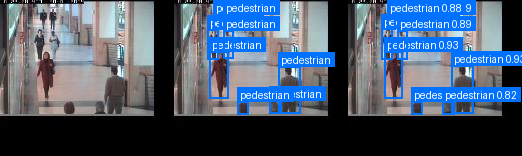

set00_set05-occ_28_jpg.rf.71c4a1de2d91407b94a6c1a15a2b0a5f: Ground truth=3 | Pred=3


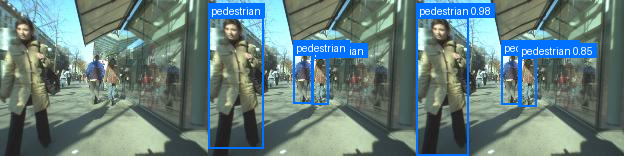

set00_set04-occ_43_jpg.rf.2143e735d9a04d78f01541555ec1c511: Ground truth=2 | Pred=2


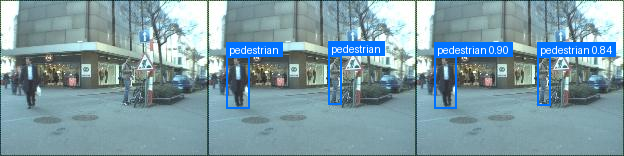

set00_set00-occ_11_jpg.rf.f9e0bdf109668ecaef86d9e028afb155: Ground truth=2 | Pred=2


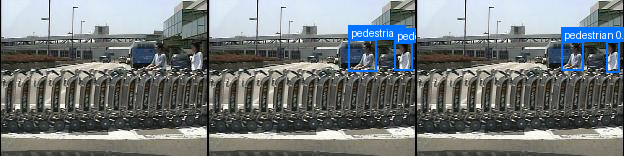

set00_set04-occ_37_jpg.rf.92bdb0f63fb69b09843af03461a81350: Ground truth=2 | Pred=2


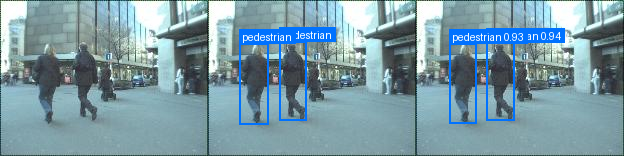

In [22]:
best_model_path = "/content/pedestrian_detection/yolov8l_pedestrian_1/weights/best.pt"
CONF_THRESH = 0.25
SAMPLE_N = 5

BLUE = (0, 114, 255)

model = YOLO(best_model_path)
model.model.names = {0: "pedestrian"}

test_img_dir = os.path.join(DIR, "test", "images")
preds = model.predict(
    source=test_img_dir,
    imgsz=640,
    conf=CONF_THRESH,
    iou=0.6,
    device=0,
    save=True,
    save_txt=True,
    save_conf=True,
    project="pedestrian_detection",
    name="test_preds",
    verbose=True
)

pred_dir = preds[0].save_dir
pred_imgs = sorted(glob.glob(os.path.join(pred_dir, "*.jpg")) +
                   glob.glob(os.path.join(pred_dir, "*.png")))
pred_label_dir = os.path.join(pred_dir, "labels")

def load_txt(path):
    rows = []
    if os.path.isfile(path):
        with open(path) as f:
            for ln in f:
                vals = ln.strip().split()
                if vals:
                    rows.append([float(v) for v in vals])
    return rows

def find_orig(test_dir, stem):
    for ext in (".jpg", ".jpeg", ".png"):
        p = os.path.join(test_dir, stem + ext)
        if os.path.isfile(p):
            return p
    return None

def draw_boxes(image, rows, is_pred=False):
    W, H = image.size
    out = image.copy()
    draw = ImageDraw.Draw(out)
    font = ImageFont.load_default()

    for r in rows:
        if is_pred:
            if len(r) < 6:
                continue
            cls, x, y, w, h, conf = r[:6]
            if conf < CONF_THRESH:
                continue
            label = f"pedestrian {conf:.2f}"
        else:
            if len(r) < 5:
                continue
            cls, x, y, w, h = r[:5]
            label = "pedestrian"

        x = min(max(x, 0.0), 1.0); y = min(max(y, 0.0), 1.0)
        w = min(max(w, 0.0), 1.0); h = min(max(h, 0.0), 1.0)

        cx, cy, bw, bh = x * W, y * H, w * W, h * H
        x1, y1 = cx - bw/2, cy - bh/2
        x2, y2 = cx + bw/2, cy + bh/2

        # blue box
        draw.rectangle([x1, y1, x2, y2], outline=BLUE, width=2)

        # blue label and white text
        tx0, ty0, tx1, ty1 = draw.textbbox((0, 0), label, font=font)
        tw, th = tx1 - tx0, ty1 - ty0
        bx1 = int(x1)
        by1 = max(0, int(y1) - th - 4)
        draw.rectangle([bx1, by1, bx1 + tw + 6, by1 + th + 4], fill=BLUE)
        draw.text((bx1 + 3, by1 + 2), label, fill=(255, 255, 255), font=font)

    return out

# visualisations
gt_label_dir = os.path.join(DIR, "test", "labels")
samples = random.sample(pred_imgs, min(SAMPLE_N, len(pred_imgs)))

for img_path in samples:
    stem = os.path.splitext(os.path.basename(img_path))[0]
    orig_path = find_orig(test_img_dir, stem)

    orig = Image.open(orig_path).convert("RGB")

    gt_rows = load_txt(os.path.join(gt_label_dir, stem + ".txt"))
    pred_rows = load_txt(os.path.join(pred_label_dir, stem + ".txt"))

    gt_img = draw_boxes(orig, gt_rows, is_pred=False)
    pred_img = draw_boxes(orig, pred_rows, is_pred=True)

    pred_count = sum(1 for r in pred_rows if len(r) >= 6 and r[5] >= CONF_THRESH)
    print(f"{stem}: Ground truth={len(gt_rows)} | Pred={pred_count}")

    canvas = Image.new("RGB", (orig.width * 3, orig.height))
    canvas.paste(orig, (0, 0))
    canvas.paste(gt_img, (orig.width, 0))
    canvas.paste(pred_img, (orig.width * 2, 0))
    display(canvas)


Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8x6 summary (fused): 147 layers, 97,280,916 parameters, 0 gradients, 260.7 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 4.4±2.2 MB/s, size: 8.6 KB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/FreshStart/pedestrian.v1i.yolov8/test/labels.cache... 48 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 48/48 97.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.8it/s 3.6s
                   all         48        207      0.903      0.845      0.937      0.704
Speed: 3.0ms preprocess, 60.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/runs/detect/val7
Precision: 0.9031 | Recall: 0.8454
mAP@50  : 0.9373
mAP@50-95: 0.7041


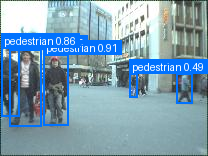

In [27]:
# paths
BEST_WEIGHTS = "/content/pedestrian_detection/yolov8l_pedestrian_1/weights/best.pt"
TEST_IMG_DIR = os.path.join(DIR, "test", "images")

BLUE = (0, 114, 255)

def load_names(yaml_path):
    try:
        with open(yaml_path, "r") as f:
            y = yaml.safe_load(f)
        names = y.get("names", ["pedestrian"])
        if isinstance(names, dict):  # {0:"pedestrian"}
            return [names[k] for k in sorted(names.keys())]
        return list(names)
    except Exception:
        return ["pedestrian"]

def draw_preds_blue(image_path, result, class_names, conf_thresh=0.30):

    img = Image.open(image_path).convert("RGB")
    W, H = img.size
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()

    if hasattr(result, "boxes") and result.boxes is not None:
        for b in result.boxes:
            conf = float(b.conf[0].item()) if b.conf is not None else 1.0
            if conf < conf_thresh:
                continue
            cls_id = int(b.cls[0].item()) if b.cls is not None else 0
            name = class_names[cls_id] if 0 <= cls_id < len(class_names) else "pedestrian"

            x1, y1, x2, y2 = [float(v) for v in b.xyxy[0].tolist()]
            draw.rectangle([x1, y1, x2, y2], outline=BLUE, width=2)

            # label
            label = f"{name} {conf:.2f}"
            tx0, ty0, tx1, ty1 = draw.textbbox((0, 0), label, font=font)
            tw, th = tx1 - tx0, ty1 - ty0
            bx1 = int(x1)
            by1 = max(0, int(y1) - th - 4)
            draw.rectangle([bx1, by1, bx1 + tw + 6, by1 + th + 4], fill=BLUE)
            draw.text((bx1 + 3, by1 + 2), label, fill=(255, 255, 255), font=font)

    display(img)

def after_training_analysis():
    model = YOLO(BEST_WEIGHTS)
    class_names = load_names(YAML_IN)
    model.model.names = {i: n for i, n in enumerate(class_names)}

    metrics = model.val(data=YAML_IN, split="test", verbose=True)
    print(f"Precision: {metrics.box.mp:.4f} | Recall: {metrics.box.mr:.4f}")
    print(f"mAP@50  : {metrics.box.map50:.4f}")
    print(f"mAP@50-95: {metrics.box.map:.4f}")

    if os.path.isdir(TEST_IMG_DIR):
        imgs = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith((".jpg",".jpeg",".png"))]
        if imgs:
            sample = random.choice(imgs)
            sample_path = os.path.join(TEST_IMG_DIR, sample)

            results = model.predict(
                source=sample_path,
                imgsz=640,
                conf=0.30,
                iou=0.60,
                device=0,
                save=False,
                verbose=False
            )
            draw_preds_blue(sample_path, results[0], class_names, conf_thresh=0.30)

    return model, metrics

final_model, final_metrics = after_training_analysis()